### 1. Importing Libraries

In [ ]:
# Libraries for loading of dataset and forming the dataframe
import pandas as pd
import json
import os
import glob

# Libraries for statistical operations
import numpy as np
import scipy.stats as stats

# Libraries for Data Visualisation
from matplotlib import pyplot as plt
import seaborn as sns

# Libraries and utilities for Data Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import joblib
# For pre-procesing text fields (Natural Language Processing)
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# For splitting and resampling data
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline

# For Hyperparameter Tuning
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV

# Libraries and utilities for step 1 Binary classification
from sklearn.ensemble import RandomForestClassifier
# For classification model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix


# Libraries and utilities for step 2 Regression analysis
from sklearn.ensemble import RandomForestRegressor
# For regression model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SAUMITA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SAUMITA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SAUMITA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2.a. Loading the dataset

In [12]:
# Function for loading the dataset files
def load_files(file_list):
    """
    This function loads and parses JSON data from a list of files.
    Args:
        file_list : A list of file paths to JSON files.
    Returns:
        data_list: A list of JSON objects, where each object 
        represents a corresponding file in 'file_list'.
    """

    # Initialise a list to store data from each file
    data_list = []
    
    # Iterate over the list of files
    for file in file_list:
        with open(file, 'r') as f:
            # Load the JSON data from the file and append it to the data_list
            data_list.append(json.load(f))
    return data_list

In [13]:
# Function to extract metadata from reviews
def extract_metadata(json_data):
    """
    This function extracts key review metadata from a JSON object.
    Args:
        json_data (dict): A dictionary where each key is a review ID and the 
                          value contains review attributes.
    Returns:
        list of dict: A list of dictionaries, each containing extracted review 
                      metadata, including 'review_id', 'overall', 'verified', 
                      'reviewTime', 'reviewerID', 'asin', 'reviewText', 
                      'summary', and 'unixReviewTime'.
    """

    reviews = []
    for review_id, review in json_data.items():
        reviews.append({
            "review_id": review_id,
            "overall": review["overall"],
            "verified": review["verified"],
            "reviewTime": review["reviewTime"],
            "reviewerID": review["reviewerID"],
            "asin": review["asin"],
            "reviewText": review["reviewText"],
            "summary": review["summary"],
            "unixReviewTime": review["unixReviewTime"]
        })
    return reviews


# Function to extract data from annotated files
def extract_annotations(json_data):
    """
    This function extracts and processes annotation data from a JSON object.
    Args:
        json_data (dict): A dictionary where each key is a review ID and the value 
                          is another dictionary mapping features to their respective 
                          vote counts (a dictionary of feature names and their vote counts).
    Returns:
        tuple:
            dict: A dictionary where each key is a review ID and the value is a 
                  dictionary of the chosen feature for each annotation.
            int: The count of reviews that had a tie in votes for at least one feature.
    """
     
    annotations = {}
    split_vote_count = 0

    # Iterate over each review and its corresponding annotation
    for review_id, annotation in json_data.items():
        annotations[review_id] = {}
        # Iterate over each feature and its corresponding vote counts
        for feature, counts in annotation.items():
            # Find the maximum vote count for the feature
            max_count = max(counts.values())
            max_features = [k for k, v in counts.items() if v == max_count]

            if len(max_features) > 1:
                split_vote_count += 1
                chosen_feature = sorted(max_features)[0]
            else:
                chosen_feature = max_features[0]
            
            # Store the chosen feature for the current feature in the review
            annotations[review_id][feature] = chosen_feature

    return annotations, split_vote_count


# Function to combine data from metadata and annotations
def combine_data(extracted_metadata, extracted_annotations, file_paths):
    """
    This function combines review metadata with corresponding annotations, and adds category information.
    Args:
        extracted_metadata (list of list of dict): A list where each element is a list of 
                                                   review metadata dictionaries for a particular file.
        extracted_annotations (list of tuple): A list of tuples where each tuple contains:
                                               - A dictionary mapping review IDs to their annotations.
                                               - An integer (not used in this function).
        file_paths (list of str): A list of file paths corresponding to the metadata and 
                                  annotation files, used to extract category information.
    Returns:
        list of dict: A list of combined review data dictionaries, where each dictionary 
                      contains review metadata, annotations, and the category of the review.
    """

    # Initialise a list to store the combined metadata and annotations
    combined_data = []

    # Iterate over the extracted metadata, annotations and file paths
    for metadata, (annotations, _), file_path in zip(extracted_metadata, extracted_annotations, file_paths):
        # Extract category names from file path
        category = os.path.basename(file_path).replace('_annotated.json', '').replace('_', ' ')
        
        # Iterate over each review in metadata
        for review in metadata:
            # Extract the review_id and get the corresponding annotations
            review_id = review['review_id']
            review.update(annotations.get(review_id, {}))
            review['category'] = category
            combined_data.append(review)
    return combined_data


### 2.b. Forming the dataframe combining the datasets

In [ ]:
# Specify the directories where the files are located
review_dir = "Review_Metadata_all_product_categories"
annotation_dir = "Summary_Annotations"

# Get all JSON files in the specified directories
review_files = glob.glob(os.path.join(review_dir, "*.json"))
annotation_files = glob.glob(os.path.join(annotation_dir, "*.json"))

# Load all files
metadata_list = load_files(review_files)
annotations_list = load_files(annotation_files)

# Extract data from the files loaded
extracted_metadata = [extract_metadata(data) for data in metadata_list]
extracted_annotations = [extract_annotations(data) for data in annotations_list]

# Combine the extracted data
combined_data = combine_data(extracted_metadata, extracted_annotations, review_files)

# Convert the combined data to a DataFrame
df = pd.DataFrame(combined_data)
df = df.rename(columns={'overall': 'reviewer_overall_product_rating', 'OVERALL': 'annotated_overall'})

df['unique_review_id'] = range(len(df))

# Reorder columns to make 'unique_review_id' the first column
columns = ['unique_review_id', 'category'] + [col for col in df.columns if col not in ['unique_review_id', 'category']]
df = df[columns]

# Save DataFrame to a CSV File - Optional
# df.to_csv('combined_reviews.csv', index=False)


In [16]:
# View DataFrame
df.head()

,unique_review_id,category,review_id,reviewer_overall_product_rating,verified,reviewTime,reviewerID,asin,reviewText,summary,...,Efficiency,Excellence,Status,Esteem,Play,Aesthetics,Ethics,Spirituality,annotated_overall,Clarity of Sentiment
0,0,All Beauty,0,5.0,True,"03 10, 2016",A5TA1NJOC0PJ5,7414204790,Excellent very good,Five Stars,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,3
1,1,All Beauty,2,5.0,True,"10 3, 2014",A80M2286B7STE,7414204790,Magical,Five Stars,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,1,4,1
2,2,All Beauty,1,5.0,True,"09 1, 2015",A1TJICB7VLGQKL,7414204790,Great product,Five Stars,...,n/a,4,n/a,n/a,n/a,n/a,n/a,n/a,4,1
3,3,All Beauty,3,5.0,True,"08 7, 2014",A2TM2MAA8IT34U,7414204790,Excellent!!!,Five Stars,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,4,1
4,4,All Beauty,4,4.0,True,"06 14, 2014",AQGWT465GTEJG,7414204790,I do like the product a lot...I had bought the...,Very pricey,...,2,n/a,n/a,n/a,n/a,n/a,n/a,n/a,2,4


### 3. Data Preprocessing

In [17]:
# Check data types of all the columns before pre-processing them to suitable formats
print(df.dtypes)

unique_review_id                     int64
category                            object
review_id                           object
reviewer_overall_product_rating    float64
verified                              bool
reviewTime                          object
reviewerID                          object
asin                                object
reviewText                          object
summary                             object
unixReviewTime                       int64
Feature Usage                       object
Interaction Time                    object
Context Experience                  object
Efficiency                          object
Excellence                          object
Status                              object
Esteem                              object
Play                                object
Aesthetics                          object
Ethics                              object
Spirituality                        object
annotated_overall                   object
Clarity of 

#### 3.a. Convert columns 'category', 'verified', 'review_id', 'reviewerID', and 'asin' to numeric data

In [18]:
# Pre-processing 'category' column - assign a numeric value for each category by Label Encoding
category_label_encoder = LabelEncoder()
df['category'] = category_label_encoder.fit_transform(df['category'])
# Save the encoder
joblib.dump(category_label_encoder, 'category_label_encoder.pkl')

# Pre-processing 'verified' column - assign an integer value for True/False
df['verified'] = df['verified'].astype(int)

# Pre-processing 'review_id' column - convert to integer type
df['review_id'] = df['review_id'].astype(int)

# Pre-processing 'reviewerID' and 'asin' columns using Label Encoding
reviewerID_label_encoder = LabelEncoder()
df['reviewerID'] = reviewerID_label_encoder.fit_transform(df['reviewerID'])
joblib.dump(reviewerID_label_encoder, 'reviewerID_label_encoder.pkl')

asin_label_encoder = LabelEncoder()
df['asin'] = asin_label_encoder.fit_transform(df['asin'])
joblib.dump(asin_label_encoder, 'asin_label_encoder.pkl')


# Check the converted values
print("Category unique values : ", df['category'].unique())
print("Verified unique values : ", df['verified'].unique())
print("Review id unique values : ", df['review_id'].unique())

Category unique values :  [ 1  0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Verified unique values :  [1 0]
Review id unique values :  [ 0  2  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


#### 3.b. Preprocess the 'reviewTime' column using datetime

In [19]:
# Pre-processing 'reviewTime' column - separate year, month and day from the datetime data
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['reviewYear'] = df['reviewTime'].dt.year
df['reviewMonth'] = df['reviewTime'].dt.month
df['reviewDay'] = df['reviewTime'].dt.day

# Drop the original 'reviewTime' column
df = df.drop('reviewTime', axis=1)

#### 3.c. Preprocessing the text columns - 'reviewText' and 'summary'

Tokenising here refers to the process of splitting the sentences into individual words or tokens.  
Stopwords removal involves filtering out common words like 'the', 'and' from the text which have little or no contextual importance.   
Lemmatising reduces words to their base form by removing transforming word forms. For example, 'freshening' becomes 'fresh'.

In [20]:
# Pre-processing the text columns - 'reviewText' and 'summary'

text_columns = ['reviewText', 'summary']

lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    This function preprocesses the input text by tokenising, removing stopwords and lemmatising.
    Args:
        text (str): The input text to preprocess.
    Returns:
        str: The cleaned text with stopwords removed.
    """

    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize the tokens
    tokens_cleaned = [
        lemmatizer.lemmatize(token.lower()) for token in tokens 
        if token.lower() not in stop_words and token.isalpha()
    ]
    return " ".join(tokens_cleaned)


for col in text_columns:
    df[col] = df[col].apply(lambda x: preprocess_text(x) if isinstance(x, str) else x)

# Define the preprocessing pipeline for text columns separately
preprocessor = ColumnTransformer(
    transformers=[
        ('reviewText_tfidf', TfidfVectorizer(max_features=1000, stop_words='english', sublinear_tf=True), 'reviewText'),
        ('summary_tfidf', TfidfVectorizer(max_features=500, stop_words='english', sublinear_tf=True), 'summary'),
        ('num', StandardScaler(), ['category', 'verified', 'reviewerID', 'asin', 'unixReviewTime', 'reviewYear', 'reviewMonth', 'reviewDay'])
    ])


#### 3.d. Categorising the input and target variables

In [ ]:
df['review_length'] = df['reviewText'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Define the input fields
input_cols = ['reviewText', 'summary', 'category', 'reviewer_overall_product_rating', 'verified', 'reviewerID', 'asin', 'unixReviewTime', 'reviewYear', 'reviewMonth', 'reviewDay', 'review_length']

# Evidence of Experience - 3 columns: Feature Usage, Interaction, Context Experience
exp_evidence = ['Feature Usage', 'Interaction Time', 'Context Experience']

# Consumer Values - 8 columns: Efficiency, Excellence, Status, Esteem, Play, Aesthetics, Ethics, Spirituality
cons_values = ['Efficiency', 'Excellence', 'Status', 'Esteem', 'Play', 'Aesthetics', 'Ethics', 'Spirituality']

In [22]:
# Remove rows where review_id > 19 as they were not annotated
df = df[df['review_id'] <= 19]

#### 3.e. Plotting data distribution

Plotting data by original overall product ratings (1 to 5) provided by the reviewer

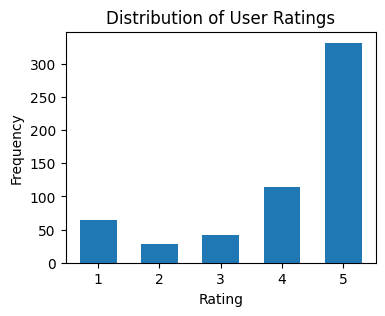

In [23]:
# Plot distribution of original user review ratings 

plt.figure(figsize=(4, 3))
plt.hist(df['reviewer_overall_product_rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], align='mid', rwidth=0.6)
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])
plt.show()


Plot percentage distribution of 'n/a' values in Evidence of Experience and Consumer Values categories


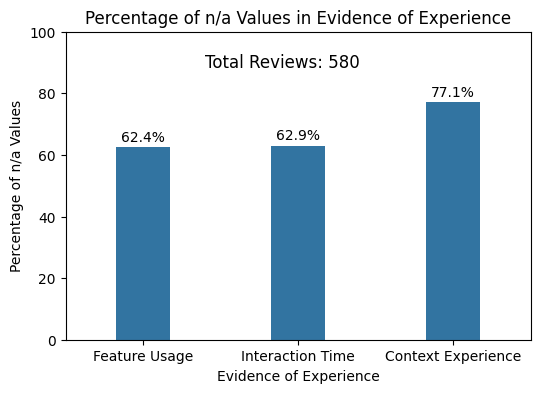

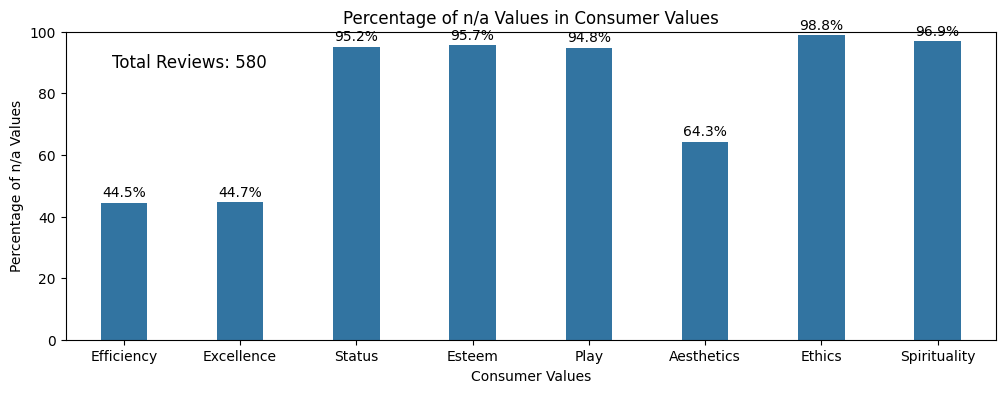

In [24]:
# Plot percentage distribution of 'n/a' values

na_arg_counts = (df[exp_evidence] == 'n/a').sum(axis=0)
na_con_counts = (df[cons_values] == 'n/a').sum(axis=0)

total_rows = df.shape[0]
na_arg_percentages = (na_arg_counts/total_rows)* 100
na_con_percentages = (na_con_counts/ total_rows) * 100


plt.figure(figsize=(6, 4))
ax1 = sns.barplot(x=na_arg_percentages.index, y=na_arg_percentages.values, width=0.35)
plt.title('Percentage of n/a Values in Evidence of Experience')
plt.xlabel('Evidence of Experience')
plt.ylabel('Percentage of n/a Values')
plt.ylim(0, 100)

# Annotate
for i, percentage in enumerate(na_arg_percentages):
    ax1.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', va='bottom')

plt.text(0.30, 0.90, f'Total Reviews: {total_rows}', fontsize=12, color='black', ha='left', va='center', transform=ax1.transAxes)

plt.show()

plt.figure(figsize=(12, 4))
ax2 = sns.barplot(x=na_con_percentages.index, y=na_con_percentages.values, width=0.4)
plt.title('Percentage of n/a Values in Consumer Values')
plt.xlabel('Consumer Values')
plt.ylabel('Percentage of n/a Values')
plt.ylim(0, 100)

for i, percentage in enumerate(na_con_percentages):
    ax2.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', va='bottom')

plt.text(0.05, 0.90, f'Total Reviews: {total_rows}', fontsize=12, color='black', ha='left', va='center', transform=ax2.transAxes)

plt.show()

In [25]:
# Calculate Spearman correlation between review length and Clarity of Sentiment values
corr, p_value = stats.spearmanr(df['review_length'], df['Clarity of Sentiment'])

# Print the results
print(f'Spearman Correlation between Review Length and Clarity of Sentiment: {corr:.2f}')
print(f'P-value: {p_value:.4f}')

Spearman Correlation between Review Length and Clarity of Sentiment: 0.44
P-value: 0.0000


The Spearman Coorelation coefficient was used to examine if there is a direct positive correlation between the review length and its clarity of sentiment.  
While the p-value (< 0.05) indicates strong statistical significance, the coefficient of 0.44 suggests only a moderate positive correlation.  
This means that while longer reviews may tend to have clearer sentiment, the relationship is not perfectly linear thereby implying the presence of other influential factors as well.

In [ ]:
# Declare a variable for all the target variables
target_vars = exp_evidence + cons_values + ['Clarity of Sentiment']

In [27]:
print(target_vars)

['Feature Usage', 'Interaction Time', 'Context Experience', 'Efficiency', 'Excellence', 'Status', 'Esteem', 'Play', 'Aesthetics', 'Ethics', 'Spirituality', 'Clarity of Sentiment']


### 4. Implementing ML models

#### 4.a. Preparing, splitting and resampling data for ML models

In [29]:
# Function to preprocess target variable
def preprocess_target(y):
    """
    This function preprocesses target labels for binary and multi-class classification.
    Args:
        y (pd.Series): A Pandas Series containing the target labels as numeric values or strings.
    Returns:
        tuple:
            y_na (pd.Series): A binary classification label (1 for 'n/a', 0 otherwise).
            y_non_na (pd.Series): A multi-class classification label (numeric values converted to integers, 
            None for 'n/a' or non-numeric values).
    """

    y = y.astype(str)
    y_na = y.apply(lambda x: 1 if x == 'n/a' else 0)  # Binary classification: 'n/a' or not
    y_non_na = y.apply(lambda x: int(float(x)) if x.replace('.', '', 1).isdigit() else None)  # Multi-class classification: 1 to 5, None for 'n/a'

    return y_na, y_non_na

In [30]:
# Function to split data into train and test sets
def split_data(X, y):
    """
    This function splits the dataset into training and test sets in the ratio 80:20.
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target label.
    Returns:
        tuple: A tuple containing four elements:
            - X_train_all (pd.DataFrame): The training set of features.
            - X_test (pd.DataFrame): The test set of features.
            - y_train_all (pd.Series): The training set of target labels.
            - y_test (pd.Series): The test set of target labels.
    """

    X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train_all, X_test, y_train_all, y_test

In [ ]:
# # Function to plot target class distribution (Optional - It was used during the initial training phase to monitor the class imbalance and effects of resampling)
# def plot_class_distribution(y, title):
#     """
#     This function plots the distribution of class labels in the target variable.

#     Args:
#         y (array-like or pandas.Series): Target variable containing class labels. Can be a NumPy array, 
#                                          pandas Series, or a single-column DataFrame.
#         title (str): Title of the plot.
    
#     Returns:
#         None. Displays a bar plot showing the distribution of the class labels with counts annotated.
#     """
    
#     # Convert y to a pandas Series if it's a numpy array
#     if isinstance(y, np.ndarray):
#         y = pd.Series(y)
#     elif isinstance(y, pd.DataFrame):
#         y = y.iloc[:, 0]
    
#     target_name = y.name if y.name else 'Target'

#     # Count the occurrences of each class
#     value_counts = y.value_counts().sort_index()
    
#     # Create DataFrame
#     value_counts_df = value_counts.reset_index()
#     value_counts_df.columns = ['Class', 'Count']
    
#     # Plot the target class distribution
#     plt.figure(figsize=(6, 4))
#     ax = sns.barplot(x='Class', y='Count', hue='Class', data=value_counts_df, palette='viridis', legend=False)
#     plt.title(f'{title} for {target_name}')
#     plt.xlabel('Class')
#     plt.ylabel('Count')
    
#     # Annotate the bars with the count values
#     for p in ax.patches:
#         ax.annotate(f'{p.get_height():.0f}', 
#             (p.get_x() + p.get_width() / 2., p.get_height()), 
#             ha='center', va='center', 
#             xytext=(0, 9), 
#             textcoords='offset points')

#     plt.show()

In [ ]:
# Function to resample data for handling imbalanced data
def resample_data(X, y):
    """
    This function resamples the dataset to address class imbalance using a combination of oversampling and undersampling.
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target labels.
    Returns:
        tuple:
            X_resampled (pd.DataFrame): The resampled features.
            y_resampled_df (pd.DataFrame): The resampled target labels as a DataFrame with the original target column name.
    """

    # Plot the original class distribution before resampling - optional call of the above optional function
    # plot_class_distribution(y, "Original Class Distribution")

    if len(np.unique(y)) <= 1:
        raise ValueError("The target 'y' needs to have more than 1 class.")
    
    target_name = y.name if isinstance(y, pd.Series) else 'target'
    y = np.ravel(y)

    # Define the undersampler to reduce the 'n/a' class
    undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
    
    # Define the oversampler to increase the samples of all other classes except 'n/a'
    oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
    
    # Create a pipeline that first applies oversampling then undersampling
    resampling_pipeline = imbPipeline(steps=[
        ('oversampler', oversampler),
        ('undersampler', undersampler)
    ])

    # Fit and resample the data
    X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)

    # Convert to DataFrame
    y_resampled_df = pd.DataFrame(y_resampled, columns=[target_name])

    # Plot the resampled class distribution - optional function call to view the distribution after resampling
    # plot_class_distribution(y_resampled_df, "Resampled Class Distribution")
    
    return X_resampled, y_resampled_df

In [32]:
# Combined Function to split data into train and test sets, and resample
def split_and_resample(X, y):
    """
    This function splits the data into training and test sets, preprocesses the target labels, 
    and applies resampling to address class imbalance, by calling respective functions where needed.
    Args:
        X (pd.DataFrame): Input features.
        y (pd.Series): Target labels containing 'n/a' and non-'n/a' values.

    Returns:
        tuple: A tuple containing eight elements:
            - X_train_resampled (pd.DataFrame): Resampled training set features.
            - X_test (pd.DataFrame): Test set features.
            - y_na_train_resampled (np.array): Resampled binary target labels ('n/a' vs non-'n/a') for training set.
            - y_na_test (pd.Series): Binary target labels ('n/a' vs non-'n/a') for test set.
            - X_train_non_na (pd.DataFrame): Training set features for non-'n/a' samples (for regression).
            - y_train_non_na (pd.Series): Training set target labels for non-'n/a' samples (for regression).
            - X_test_non_na (pd.DataFrame): Test set features for non-'n/a' samples (for regression).
            - y_test_non_na (pd.Series): Test set target labels for non-'n/a' samples (for regression).

    """
    
    # Split data into train and test sets
    X_train_all, X_test, y_train_all, y_test = split_data(X,y)

    # Preprocess target variables
    y_na_train, y_non_na_train = preprocess_target(y_train_all)
    y_na_test, y_non_na_test = preprocess_target(y_test)

    # Check class balance before resampling
    if len(np.unique(y_na_train)) <= 1:
        print(f"Skipping resampling for 'n/a' vs non-'n/a' in training data due to insufficient classes.")
        return X_train_all, X_test, y_na_train, y_na_test, X_train_all.loc[y_na_train == 0], y_non_na_train[y_na_train.index][y_na_train == 0], X_test.loc[y_na_test == 0], y_non_na_test[y_na_test.index][y_na_test == 0]

    # Apply undersampling/oversampling to balance 'n/a' vs. non-'n/a' classes in the training set
    X_train_resampled, y_na_train_resampled = resample_data(X_train_all, y_na_train)
    y_na_train_resampled = np.ravel(y_na_train_resampled)

    # Check class balance for non-'n/a' samples
    if len(np.unique(y_non_na_train)) <= 1:
        print(f"Skipping resampling for non-'n/a' classes due to insufficient classes.")
        return X_train_resampled, X_test, y_na_train_resampled, y_na_test, X_train_all.loc[y_na_train == 0], y_non_na_train[y_na_train.index][y_na_train == 0], X_test.loc[y_na_test == 0], y_non_na_test[y_na_test.index][y_na_test == 0]
    
    # Filter out non-'n/a' samples for regression
    X_train_non_na = X_train_all.loc[y_na_train == 0]
    y_train_non_na = y_non_na_train[y_na_train.index][y_na_train == 0]
    X_test_non_na = X_test.loc[y_na_test == 0]
    y_test_non_na = y_non_na_test[y_na_test.index][y_na_test == 0]    

    return X_train_resampled, X_test, y_na_train_resampled, y_na_test, X_train_non_na, y_train_non_na, X_test_non_na, y_test_non_na

#### 4.b. Model training and evaluation 

In [ ]:
def train_and_tune_binary_classifier(X_train, y_na_train):
    """
    This function trains and tunes Random Forest classifier for binary classification using hyperparameter
    optimisation, utilising RandomizedSearchCV with stratified k-fold cross-validation. 
    Args:
        X_train (pd.DataFrame): The training feature data.
        y_na_train (pd.Series): The training target data for binary classification ('n/a' vs non-'n/a').
    Returns:
        tuple: A tuple containing:
            - best_rf_model (Pipeline): The best Random Forest model after tuning.
            - mean_accuracy_rf (float): The mean accuracy from cross-validation of the best model.
    """

    # Define selected classifier - Random Forest
    rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
    # results = {}

    # Define the model
    rf_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', rfc)
    ])

    # Define the hyperparameter grid for Random Forest
    param_distributions = {
        'classifier__n_estimators': np.arange(5, 100, 5),
        'classifier__max_depth': [2, 5, 10, 20, None],
        'classifier__min_samples_split': [2, 4, 8, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False]
    }   

    n_samples = X_train.shape[0]
    n_splits = min(5, n_samples)

    # Define stratified k-fold cross-validation
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Perform hyperparameter tuning with RandomisedSearchCV
    random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                   n_iter=50, cv=skfold, verbose=0, random_state=42, n_jobs=-1)


    print(f"\n -------- Training and evaluating {rfc}")
    random_search.fit(X_train, y_na_train)

    best_rf_model = random_search.best_estimator_

    # Perform stratified k-fold cross-validation
    cv_scores_rf = cross_val_score(best_rf_model, X_train, y_na_train, cv=skfold)

    # Calculate the mean accuracy across cross validation
    mean_accuracy_rf = cv_scores_rf.mean()
    # print("Cross-validation scores: ", cv_scores_rf)
    print("Mean accuracy after cross-validation:", mean_accuracy_rf)

    best_rf_model.fit(X_train, y_na_train)

    return best_rf_model, mean_accuracy_rf

In [66]:
def evaluate_model_binary(model, X_test, y_test):
    """
    This function evaluates the performance of a trained binary classification model on test data,
    and provides the key evaluation metrics such as accuracy, precision, recall, f-score etc.
    Args:
        model (Pipeline): The trained binary classification model.
        X_test (pd.DataFrame): The test set input features.
        y_test (pd.Series): The true binary labels for the test set.

    Returns:
        dict: A dictionary containing the following metrics:
            - 'accuracy' (float): Accuracy of the model on the test set.
            - 'roc_auc' (float): ROC AUC score of the model.
            - 'precision' (float): Precision for class 1 ('n/a') if available.
            - 'recall' (float): Recall for class 1 ('n/a') if available.
            - 'fscore' (float): F1-score for class 1 ('n/a') if available.
            - 'confusion_matrix' (np.array): Confusion matrix for the test set.
            - 'cf_report' (dict): Full classification report in dictionary format.
    """

    # Apply the trained model to predict the test data
    y_pred = model.predict(X_test)

    # y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate the performance of the model on test data
    accuracy = accuracy_score(y_test, y_pred)
    cf_report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
    # print("Classification Report : ", cf_report)

    # Calculate the ROC AUC score
    # roc_auc = roc_auc_score(y_test, y_proba)

    results = {
        'accuracy': accuracy,   
        # 'roc_auc': roc_auc,
        # 'cf_report': cf_report,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # class 1 : n/a
    if '1' in cf_report:
        results['precision'] = cf_report['1']['precision']
        results['recall'] = cf_report['1']['recall']
        results['fscore'] = cf_report['1']['f1-score']
        results['cf_report'] = cf_report
        results['confusion_matrix']= confusion_matrix(y_test, y_pred)
        
    else:
        results['precision'] = None
        results['recall'] = None
        results['fscore'] = None
    
    return results

In [ ]:
# Function to train and evaluate regression models (Step 2)
def train_and_tune_regressor(X_train_non_na, y_train_non_na, preprocessor):
    """
    This function trains and tunes Random Forest Regressor using hyperparameter optimisation, 
    utilising RandomizedSearchCV.
    Args:
        X_train_non_na (pd.DataFrame): The training feature data with non-'n/a' values.
        y_train_non_na (pd.Series): The training target data with non-'n/a' values.
        preprocessor (Pipeline): The preprocessing pipeline to be applied to the features.

    Returns:
        tuple: A tuple containing:
            - train_rmse (float): The Root Mean Squared Error (RMSE) on the training set.
            - best_reg_model (Pipeline): The best Random Forest Regressor model after tuning.
    """

    # Define regression model
    rf_reg_model = RandomForestRegressor(random_state=42)

    # Define parameter grids for RandomizedSearchCV
    param_grid = {
        'regressor__n_estimators': np.arange(1, 50, 5),
        'regressor__max_depth': np.arange(1, 30, 5),
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }

    print(f"\n -------- Training and evaluating Random Forest Regressor")
    
    # Define the regressor model
    regressor_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', rf_reg_model)
    ])

    n_samples = X_train_non_na.shape[0]
    n_splits = min(5, n_samples) 

    # Define RandomizedSearchCV
    random_search_reg = RandomizedSearchCV(estimator=regressor_model, param_distributions=param_grid,
                                        n_iter=50, cv=n_splits, verbose=0, random_state=42, n_jobs=-1)

    # Perform the search
    random_search_reg.fit(X_train_non_na, y_train_non_na)

    # Get the best model
    best_reg_model = random_search_reg.best_estimator_

    # Return the best model and the RMSE on the training set
    y_train_pred = best_reg_model.predict(X_train_non_na)
    train_rmse = np.sqrt(mean_squared_error(y_train_non_na, y_train_pred))
    
    # Fit the best model on training data
    best_reg_model.fit(X_train_non_na, y_train_non_na)

    return train_rmse, best_reg_model

In [52]:
def evaluate_model_regressor(model, X_test, y_test):
    """
    Ths function evaluates a trained regression model on the test data and calculates key error metrics.
    Args:
        model (Pipeline): The trained regression model or pipeline that includes preprocessing and regression steps.
        X_test (pd.DataFrame): The test set of input features.
        y_test (pd.Series): The true target values for the test set.
    Returns:
        dict: A dictionary containing the following evaluation metrics:
            - "root_mean_squared_error" (float): The RMSE of the model on the test data.
            - "mean_absolute_error" (float): The MAE of the model on the test data.
            - "r2_score" (float): The R-squared score of the model, indicating the proportion of variance explained.
    """

    # Apply the trained model to predict test data
    y_pred = model.predict(X_test)

    # Evaluate the regressor model by error metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        "root_mean_squared_error": rmse,
        "mean_absolute_error": mae,
        "r2_score": r2,
    }

#### 4.c. Model Implementation - on 12 target variables

In [67]:
# Declare dictionaries to store true values and predicted values
true_values_reg = {}
pred_values_reg = {}

# Prepare the feature matrix X
X = df[input_cols]
results = {}

# Prepare step 1 target variables as all variables except 'Clarity of Sentiment'
step1_target_vars = [target for target in target_vars if target not in ['Clarity of Sentiment']]

# Initialise dictionary for storing all the results
all_results = {
    'binary_classification': {},
    'regression': {}
}

binary_train_accuracy = {}
reg_train_RMSE = {}

# Run loop across all target variables
for target in target_vars:
    y = df[target]
    
    if target in step1_target_vars:

        # Perform sampling and split data
        X_train, X_test, y_na_train, y_na_test, X_train_non_na, y_train_non_na, X_test_non_na, y_test_non_na = split_and_resample(X, y)

        # ravelling
        y_na_train = np.ravel(y_na_train)
        y_na_test = np.ravel(y_na_test)
        y_train_non_na = np.ravel(y_train_non_na)
        y_test_non_na = np.ravel(y_test_non_na)

        # Step 1: Binary Classification
        print("\n -------------------------------------------------------------------------------")
        print(f"\n Step 1 results for '{target}': Binary Classification ('n/a' vs Non-'n/a') \n")
        
        best_clf_model, mean_accuracy = train_and_tune_binary_classifier(X_train, y_na_train)
        binary_train_accuracy[target] = mean_accuracy
        binary_results = evaluate_model_binary(best_clf_model, X_test, y_na_test)
        
        all_results['binary_classification'][target] = binary_results


    # For the target variable 'Clariy of Sentiment', apply only Regression
    if (target == 'Clarity of Sentiment'):
       
        X_train, X_test, y_train, y_test = split_data(X, y)
        X_train_resampled, y_train_resampled = resample_data(X_train, y_train)

        y_train_resampled = np.ravel(y_train_resampled)

        # Apply Regression
        print(f"\n Regression results for '{target}': Regression Analysis \n")
        train_rmse, best_reg_model = train_and_tune_regressor(X_train_resampled, y_train_resampled, preprocessor)
        reg_train_RMSE[target] = train_rmse
        
        regression_results = {}
        print(f"Training RMSE for Random Forest Regressor: {train_rmse}")

        # Make predictions and store true and predicted values
        true_values_reg[target] = pd.DataFrame({'true': y_test, 'reviewText': X_test['reviewText'], 
                                                'category': X_test['category']})
        pred_values_reg[target] = pd.DataFrame({'predicted': best_reg_model.predict(X_test), 
                                                'reviewText': X_test['reviewText'], 'category': X_test['category']})

        regression_results = evaluate_model_regressor(best_reg_model, X_test, y_test)

        all_results['regression'][target] = regression_results
    
    else:  

        # Apply resampling before regression (Step 2)
        X_train_non_na_resampled, y_train_non_na_resampled = resample_data(X_train_non_na, y_train_non_na)

        y_train_non_na_resampled = np.ravel(y_train_non_na_resampled)
        
        # Step 2: Regression
        print(f"\n Step 2 results for '{target}': Regression Analysis \n")
        train_rmse, best_reg_model = train_and_tune_regressor(X_train_non_na_resampled, y_train_non_na_resampled, preprocessor)
        reg_train_RMSE[target] = train_rmse

        # Make predictions and store true and predicted values
        true_values_reg[target] = pd.DataFrame({'true': y_test_non_na,
                                                'reviewText': X_test_non_na['reviewText'], 'category': X_test_non_na['category']})
        pred_values_reg[target] = pd.DataFrame({'predicted': best_reg_model.predict(X_test_non_na), 
                                                'reviewText': X_test_non_na['reviewText'], 'category': X_test_non_na['category']})

        regression_results = {}
        print(f"Training RMSE for Random Forest Regressor: {train_rmse}")
        regression_results = evaluate_model_regressor(best_reg_model, X_test_non_na, y_test_non_na)

        all_results['regression'][target] = regression_results



 -------------------------------------------------------------------------------

 Step 1 results for 'Feature Usage': Binary Classification ('n/a' vs Non-'n/a') 


 -------- Training and evaluating RandomForestClassifier(class_weight='balanced', random_state=42)
Mean accuracy after cross-validation: 0.8396524711579547

 Step 2 results for 'Feature Usage': Regression Analysis 


 -------- Training and evaluating Random Forest Regressor
Training RMSE for Random Forest Regressor: 0.212220341162469

 -------------------------------------------------------------------------------

 Step 1 results for 'Interaction Time': Binary Classification ('n/a' vs Non-'n/a') 


 -------- Training and evaluating RandomForestClassifier(class_weight='balanced', random_state=42)
Mean accuracy after cross-validation: 0.8507422969187675

 Step 2 results for 'Interaction Time': Regression Analysis 


 -------- Training and evaluating Random Forest Regressor
Training RMSE for Random Forest Regressor: 0.266850

c:\Users\SAUMITA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Training RMSE for Random Forest Regressor: 1.0226250035499806

 -------------------------------------------------------------------------------

 Step 1 results for 'Spirituality': Binary Classification ('n/a' vs Non-'n/a') 


 -------- Training and evaluating RandomForestClassifier(class_weight='balanced', random_state=42)
Mean accuracy after cross-validation: 1.0

 Step 2 results for 'Spirituality': Regression Analysis 


 -------- Training and evaluating Random Forest Regressor
Training RMSE for Random Forest Regressor: 0.11785113019775792

 Regression results for 'Clarity of Sentiment': Regression Analysis 


 -------- Training and evaluating Random Forest Regressor
Training RMSE for Random Forest Regressor: 0.41527196159000196


#### 4.d. Auxiliary analysis: Predicting overall product rating

In [65]:
# target variable : 'reviewer_overall_product_rating'

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Input fields for predicting 'reviewer_overall_product_rating'
input_cols = ['reviewText', 'summary', 'category', 'verified', 'reviewerID', 'asin', 'unixReviewTime', 'reviewYear', 'reviewMonth', 'reviewDay', 'review_length']

# Target variable
target_rating = "reviewer_overall_product_rating"

# Prepare full dataset
X = df[input_cols]
y_rating = df[target_rating]

# Split and resample training data
X_train_rating, X_test_rating, y_train_rating, y_test_rating = split_data(X, y_rating)
X_train_rating_resampled, y_train_rating_resampled = resample_data(X_train_rating, y_train_rating)

y_train_rating_resampled = np.ravel(y_train_rating_resampled)

# Train model using existing function
train_rmse_rating, best_reg_model_rating = train_and_tune_regressor(
    X_train_rating_resampled, y_train_rating_resampled, preprocessor
)


# Predict on training set using cross_val_predict
n_splits = min(5, X_train_rating.shape[0])
train_preds = cross_val_predict(best_reg_model_rating, X_train_rating, y_train_rating, cv=n_splits)

train_results = pd.DataFrame({
    'index': X_train_rating.index,
    'true_rating': y_train_rating.ravel(),
    'predicted_rating': train_preds
})


# Predict on test set 
print("\nGenerating test set predictions for 'reviewer_overall_product_rating'...")
test_preds_rating = best_reg_model_rating.predict(X_test_rating)

# Evaluation metrics
test_rmse_rating = np.sqrt(mean_squared_error(y_test_rating, test_preds_rating))
test_mae_rating = mean_absolute_error(y_test_rating, test_preds_rating)
test_r2_rating = r2_score(y_test_rating, test_preds_rating)

# Print results
print(f"Test RMSE: {test_rmse_rating:.4f}")
print(f"Test MAE: {test_mae_rating:.4f}")


test_results_rating = pd.DataFrame({
    'index': X_test_rating.index,
    'true_rating': y_test_rating,
    'predicted_rating': test_preds_rating
})
test_results_rating.set_index('index', inplace=True)




 -------- Training and evaluating Random Forest Regressor

Generating test set predictions for 'reviewer_overall_product_rating'...
Test RMSE: 1.4420
Test MAE: 1.2130


In [ ]:
# Add prediction results of 'reviewer_overall_product_rating' to 'all_results' for plotting
# There are only regression results for 'reviewer_overall_product_rating'
all_results['regression']['reviewer_overall_product_rating'] = {
    'root_mean_squared_error': test_rmse_rating,
    'mean_absolute_error': test_mae_rating,
}

In [ ]:
# Check all results
print(all_results['regression'])

{'Feature Usage': {'root_mean_squared_error': 0.8316378247123803, 'mean_absolute_error': 0.7039198906247282, 'r2_score': 0.562154044383173}, 'Interaction Time': {'root_mean_squared_error': 1.0031127339228838, 'mean_absolute_error': 0.7532165193799554, 'r2_score': -0.22018717770542384}, 'Context Experience': {'root_mean_squared_error': 1.0774900688567148, 'mean_absolute_error': 0.8636363636363636, 'r2_score': -0.28879969418960205}, 'Efficiency': {'root_mean_squared_error': 1.414349797501921, 'mean_absolute_error': 1.216276021809218, 'r2_score': 0.07008328888345883}, 'Excellence': {'root_mean_squared_error': 1.3212093342043623, 'mean_absolute_error': 1.0392504287841575, 'r2_score': 0.10303406314640828}, 'Status': {'root_mean_squared_error': 0.8938073370223755, 'mean_absolute_error': 0.7525764895330114, 'r2_score': -0.19833733357254557}, 'Esteem': {'root_mean_squared_error': 0.45643546458763834, 'mean_absolute_error': 0.38888888888888884, 'r2_score': 0.06250000000000044}, 'Play': {'root_m

### 5. Visualisation of test result metrics

In [47]:
# Plot combined results for Binary Classification
def plot_combined_binary_classification_results(all_results):
    """
    This function plots binary classification metrics across all target variables in a grouped bar plot.
    Args:
        all_results (dict): A dictionary containing the evaluation results for binary classification, 
                        with each target variable having its associated metrics.           
    Returns:
        None: Displays a bar plot of the classification metrics.
    """

    plot_data = []
    for target, metrics in all_results['binary_classification'].items():

        # Append metric values to the plot_data list
        if 'accuracy' in metrics:
            plot_data.append({
                'Target': target,
                'Metric': 'Accuracy',
                'Value': metrics['accuracy']
            })

        if 'precision' in metrics:
            plot_data.append({
                'Target': target,
                'Metric': 'Precision',
                'Value': metrics['precision']
            })

        if 'recall' in metrics:
            plot_data.append({
                'Target': target,
                'Metric': 'Recall',
                'Value': metrics['recall']
            })

        if 'fscore' in metrics:
            plot_data.append({
                'Target': target,
                'Metric': 'F-score',
                'Value': metrics['fscore']
            })


    clf_metrics_df = pd.DataFrame(plot_data)
    custom_palette = sns.color_palette('viridis', n_colors=len(clf_metrics_df['Target'].unique()))
    
    # Plot 
    plt.figure(figsize=(20, 8))
    ax = sns.barplot(x='Metric', y='Value', hue='Target', data=clf_metrics_df, palette=custom_palette, dodge=True, width=0.9)
    plt.title('Comparison of Binary Classification Metrics across all Target variables', fontsize=18)
    plt.ylabel('Value', fontsize=20)
    plt.xlabel('Metric', fontsize=20)    
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)

    # Annotate
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

    plt.legend(loc='lower center')
    plt.show()


# Plot combined results for Regression 
def plot_combined_regression_results(all_results):
    """
    This function plots regression metrics across all target variables in a grouped bar plot.
    Args:
        all_results (dict): A dictionary containing the evaluation results for regression, 
                        with each target variable having its associated metrics.           
    Returns:
        None: Displays a bar plot of the regression metrics.
    """

    plot_data = []
    for target, metrics in all_results['regression'].items():

        # Append metric values to the plot_data list
        if 'root_mean_squared_error' in metrics:
            plot_data.append({
                'Target': target,
                'Metric': 'Root Mean Squared Error',
                'Value': metrics['root_mean_squared_error']
            })

        if 'mean_absolute_error' in metrics:
            plot_data.append({
                'Target': target,
                'Metric': 'Mean Absolute Error',
                'Value': metrics['mean_absolute_error']
            })

        # if 'r2_score' in metrics:
        #     plot_data.append({
        #         'Target': target,
        #         'Metric': 'R-squared',
        #         'Value': metrics['r2_score']
        #     })

    reg_metrics_df = pd.DataFrame(plot_data)
    custom_palette = sns.color_palette('Set3', n_colors=len(reg_metrics_df['Target'].unique())) # magma
    
    # Plot
    plt.figure(figsize=(20, 8))
    ax = sns.barplot(x='Metric', y='Value', hue='Target', data=reg_metrics_df, palette=custom_palette, dodge=True, width=0.6, errorbar=None)
    plt.title('Comparison of Regression Metrics across all target variables', fontsize=18)
    plt.ylabel('Value', fontsize=20)
    plt.xlabel('Metric', fontsize=20)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    ax.set(ylim=(0, 1.5))

    # Annotate
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

    plt.legend(loc='lower center')
    plt.show()


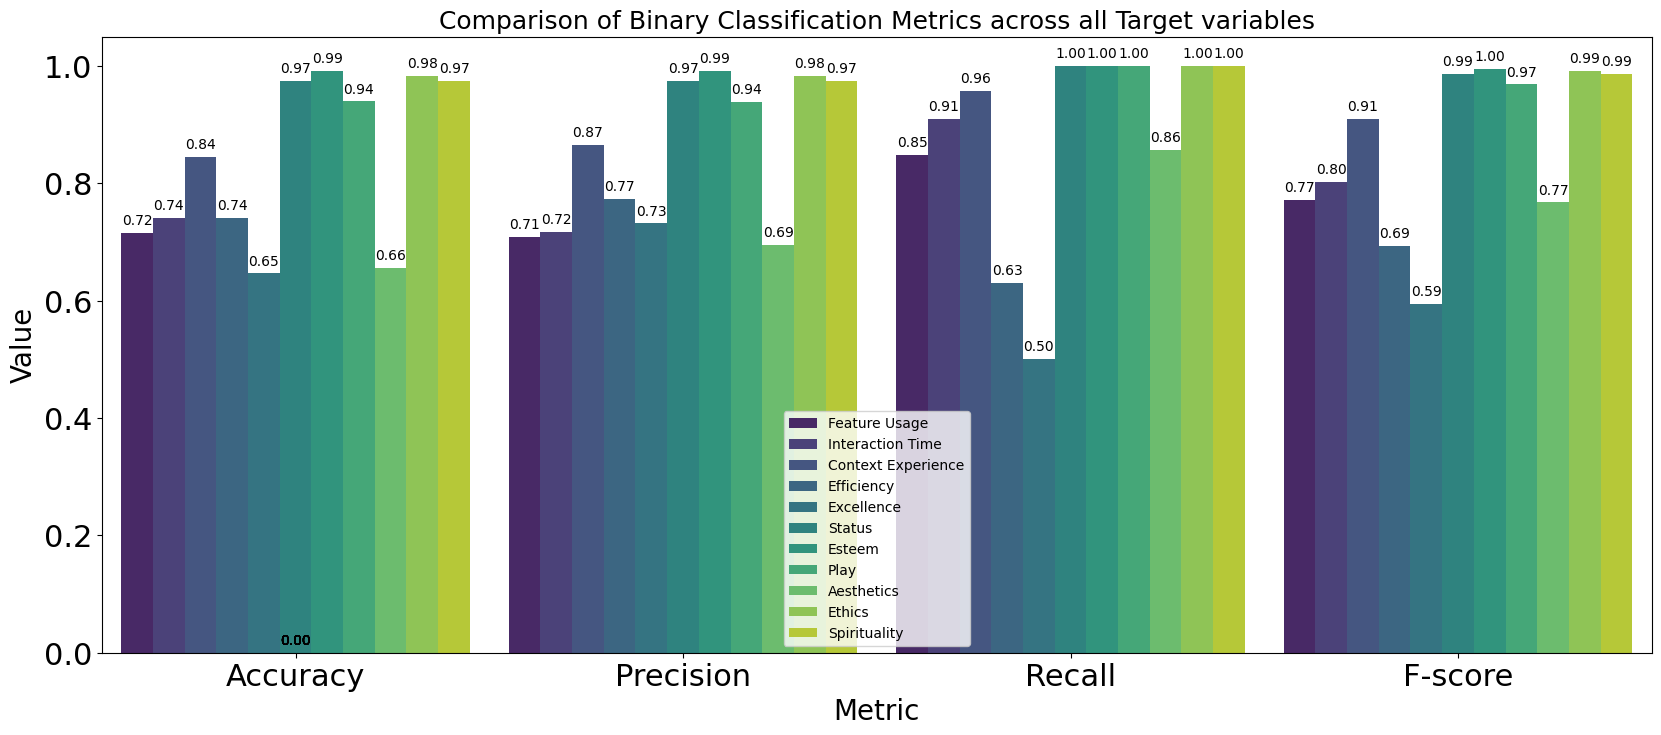

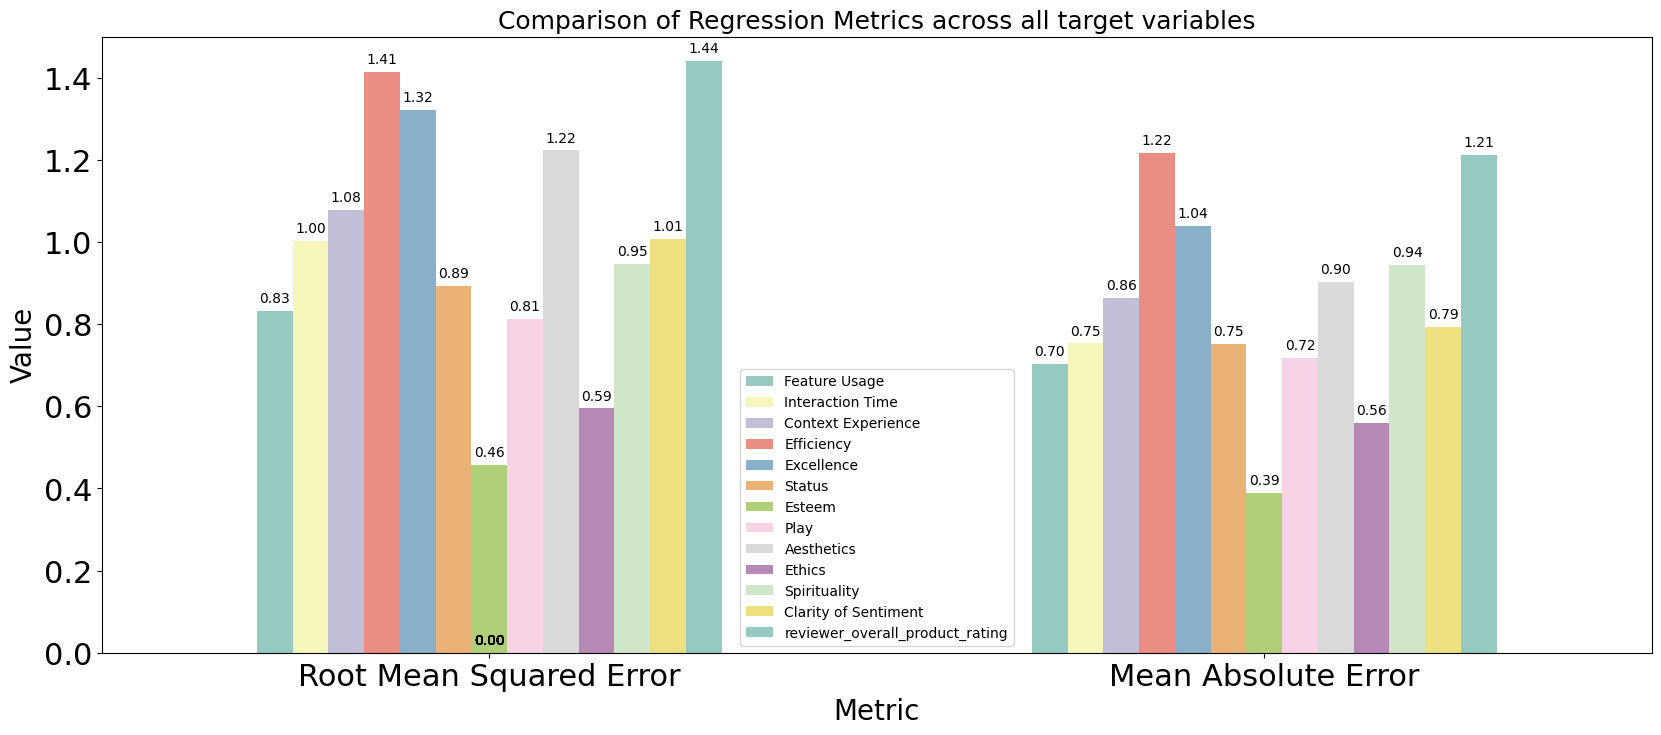

In [48]:
# Plot the comprehensive plots for classification task
plot_combined_binary_classification_results(all_results)

# Plot the comprehensive plots for regression task
plot_combined_regression_results(all_results)